# Covid 19 Analysis

In [77]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### 3.4) K-Nearest Neighbors
- - -

In [78]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,Recovered,Confirmed_inc,Confirmed_inc_norm,Deaths_inc,Deaths_inc_norm,Recovered_inc,Recovered_inc_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,NaN,0.0,-0.117725,0.0,-0.110666,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,NaN,0.0,-0.117725,0.0,-0.110666,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,183.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,183.0,25.0,-0.098276,0.0,-0.110666,59.0,0.003578
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,1267.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130


In [79]:
# define helper functions for the regression tasks
def get_coords_for_country(country, norm=True):
    if norm:
        coords = df.loc[df["Country/Region"] == "US", ["Lat_norm", "Long_norm"]].iloc[0]
    else:
        coords = df.loc[df["Country/Region"] == "US", ["Lat", "Long"]].iloc[0]
    
    return coords[0], coords[1]

#### 3.4.1) Regression for Confirmed Cases
- - -

In [80]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42], dtype=int64)

### Non normalized inputs

In [81]:
# get the inputs of the data for the machine learning algorithm
inputs_non_normalized = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs_non_normalized

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [82]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs_non_normalized, outputs, test_size=0.20, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [83]:
# create K-Nearest Neighbours instance, and check the hyper parameters)
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [84]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

# Training the model with training data
search.fit(in_conf_train, out_conf_train)
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
knn_estimator = search.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.7s


Best score: -72469262.2334754
Best parameters: {'p': 1, 'n_neighbors': 11, 'leaf_size': 28}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   53.3s finished


MAE: 1661.8025677179962
MSE: 73537556.88441761
RMSE: 8575.404181985687
R^2: 0.9317701395609124


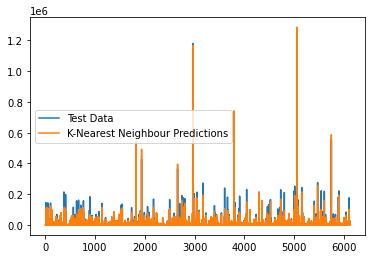

In [85]:
knn_estimator.fit(in_conf_train, out_conf_train) # tirar quando descomentar o que esta em cima
knn_estimator_pred = knn_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(knn_estimator_pred)
plt.legend(['Test Data', 'K-Nearest Neighbour Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, knn_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, knn_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, knn_estimator_pred)))
print('R^2:', r2_score(out_conf_test, knn_estimator_pred))

(array([ 3.,  0.,  5.,  6.,  8., 29., 43., 61., 37.,  8.]),
 array([0.92527016, 0.93119499, 0.93711983, 0.94304466, 0.9489695 ,
        0.95489433, 0.96081917, 0.966744  , 0.97266884, 0.97859367,
        0.98451851]),
 <a list of 10 Patch objects>)

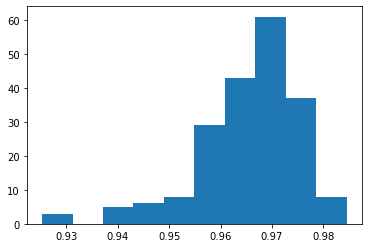

In [86]:
model_accuracies = []

for repetition in range(200):
    (accuracy_in_train,
     accuracy_in_test,
     accuracy_out_train,
     accuracy_out_test) = train_test_split(inputs_non_normalized, outputs, test_size=0.25)
    
    knn_acc = KNeighborsRegressor(p=2, n_neighbors=10, leaf_size=17)
    knn_acc.fit(accuracy_in_train, accuracy_out_train)
    
    classifier_accuracy = knn_estimator.score(accuracy_in_test, accuracy_out_test)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)

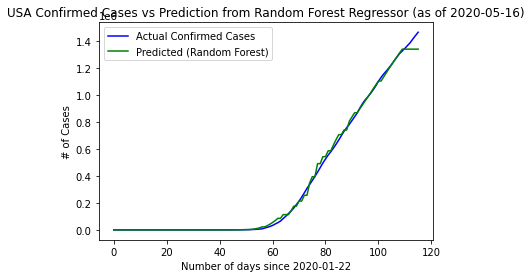

In [87]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat", "Long", "Num_days_from_begin"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = knn_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

In [ ]:
brazil_df = df.loc[df["Country/Region"] == "Brazil"]
brazil_inputs = brazil_df[["Lat", "Long", "Num_days_from_begin"]].values
brazil_outputs = brazil_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
brazil_pred_output = knn_estimator.predict(brazil_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, brazil_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, brazil_pred_output, color='green', label="Predicted (Nearest Neighbours)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Brazil Confirmed Cases vs Prediction from Nearest Neighbours (as of {})".format(last_day))
plt.legend()

In [ ]:
spain_df = df.loc[df["Country/Region"] == "Spain"]
spain_inputs = spain_df[["Lat", "Long", "Num_days_from_begin"]].values
spain_outputs = spain_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
spain_pred_output = knn_estimator.predict(spain_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, spain_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, spain_pred_output, color='green', label="Predicted (Nearest Neighbours)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Spain Confirmed Cases vs Prediction from Nearest Neighbours (as of {})".format(last_day))
plt.legend()

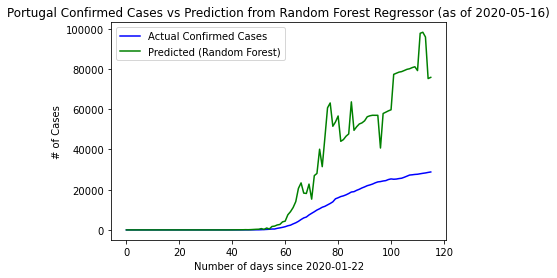

In [88]:
portugal_df = df.loc[df["Country/Region"] == "Portugal"]
portugal_inputs = portugal_df[["Lat", "Long", "Num_days_from_begin"]].values
portugal_outputs = portugal_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
portugal_pred_output = knn_estimator.predict(portugal_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, portugal_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, portugal_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Portugal Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

### Normalized values

In [89]:
# get the inputs of the data for the machine learning algorithm
inputs_normalized = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs_normalized

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [90]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs_normalized, outputs, test_size=0.20, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [91]:
# create K-Nearest Neighbours instance, and check the hyper parameters)
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [92]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

# Training the model with training data
search.fit(in_conf_train, out_conf_train)
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
knn_estimator = search.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.3s


Best score: -126964763.4937124
Best parameters: {'p': 1, 'n_neighbors': 12, 'leaf_size': 49}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   45.3s finished


MAE: 1818.6527619047622
MSE: 102177868.5278118
RMSE: 10108.30690708448
R^2: 0.957733252909667


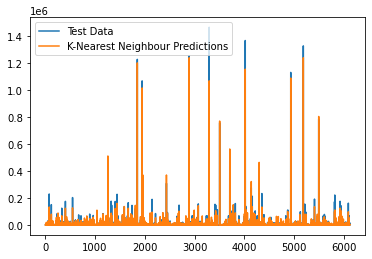

In [93]:
knn_estimator.fit(in_conf_train, out_conf_train) # tirar quando descomentar o que esta em cima
knn_estimator_pred = knn_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(knn_estimator_pred)
plt.legend(['Test Data', 'K-Nearest Neighbour Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, knn_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, knn_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, knn_estimator_pred)))
print('R^2:', r2_score(out_conf_test, knn_estimator_pred))

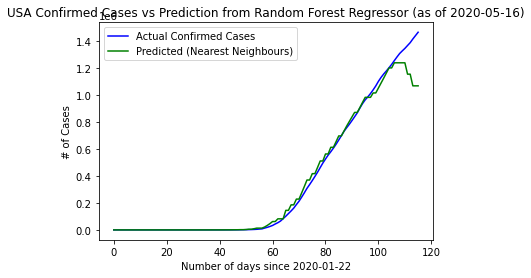

In [94]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = knn_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Nearest Neighbours)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

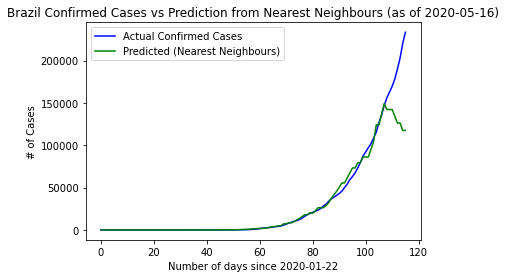

In [95]:
brazil_df = df.loc[df["Country/Region"] == "Brazil"]
brazil_inputs = brazil_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
brazil_outputs = brazil_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
brazil_pred_output = knn_estimator.predict(brazil_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, brazil_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, brazil_pred_output, color='green', label="Predicted (Nearest Neighbours)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Brazil Confirmed Cases vs Prediction from Nearest Neighbours (as of {})".format(last_day))
plt.legend()

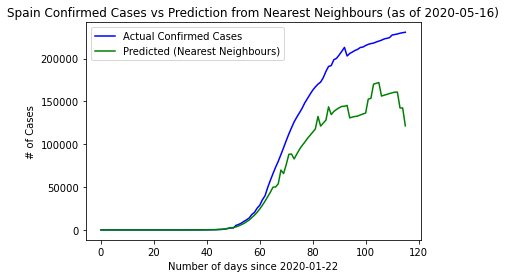

In [96]:
spain_df = df.loc[df["Country/Region"] == "Spain"]
spain_inputs = spain_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
spain_outputs = spain_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
spain_pred_output = knn_estimator.predict(spain_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, spain_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, spain_pred_output, color='green', label="Predicted (Nearest Neighbours)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Spain Confirmed Cases vs Prediction from Nearest Neighbours (as of {})".format(last_day))
plt.legend()

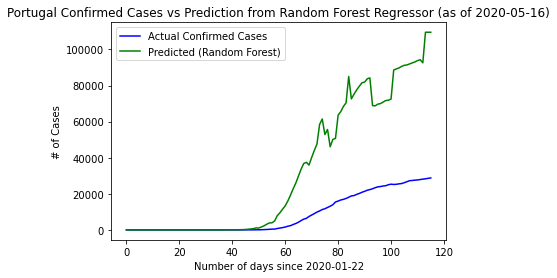

In [97]:
portugal_df = df.loc[df["Country/Region"] == "Portugal"]
portugal_inputs = portugal_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
portugal_outputs = portugal_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
portugal_pred_output = knn_estimator.predict(portugal_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, portugal_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, portugal_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Portugal Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

### Using increments as output

### Increases as inputs and cumulative as output